In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
import seaborn as sns
import xgboost as xgb

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# 导入数据 & 基础特征

In [3]:
train = pd.read_csv('../data/train.csv', header=0, dtype={'Age':np.float64})
test = pd.read_csv('../data/test.csv', header=0, dtype={'Age':np.float64})
full_data = [train, test]

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
def get_base_feature(dataset):
    dataset = dataset.copy()
    # Sex feature
    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).fillna(0).astype(int)
    
    # Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).fillna(2).astype(int)
    
    # Fare map
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] =0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].fillna(2).astype(int)
    
    #map age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    dataset['Age'] = dataset['Age'].fillna(2)
    
    #drop some feature
    drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    dataset = dataset.drop(drop_elements, axis=1)
    return dataset

In [6]:
get_base_feature(train)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,1.0,1,0,0,0
1,1,1,0,2.0,1,0,3,1
2,1,3,0,1.0,0,0,1,0
3,1,1,0,2.0,1,0,3,0
4,0,3,1,2.0,0,0,1,0
5,0,3,1,2.0,0,0,1,2
6,0,1,1,3.0,0,0,3,0
7,0,3,1,0.0,3,1,2,0
8,1,3,0,1.0,0,2,1,0
9,1,2,0,0.0,1,0,2,1


In [7]:
get_base_feature(train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int32
Embarked    891 non-null int32
dtypes: float64(1), int32(3), int64(4)
memory usage: 45.3 KB


In [8]:
get_base_feature(test).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null int32
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null int32
Embarked    418 non-null int32
dtypes: float64(1), int32(3), int64(3)
memory usage: 18.0 KB


In [9]:
train_feat = get_base_feature(train)
test_feat = get_base_feature(test)

## 测试基础特征的分类结果

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



                   Classifier       auc
0        KNeighborsClassifier  0.799214
0                         SVC  0.827166
0      RandomForestClassifier  0.832309
0          AdaBoostClassifier  0.849139
0  GradientBoostingClassifier  0.851106
0                  GaussianNB  0.844224
0  LinearDiscriminantAnalysis  0.855935
0          LogisticRegression  0.855826


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



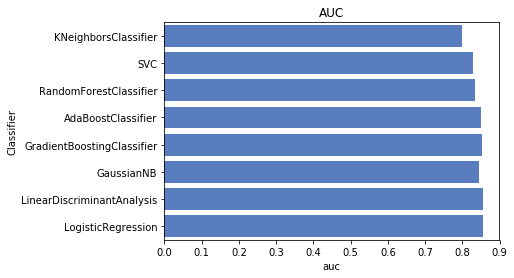

In [10]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
#     DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

auc_cols = ['Classifier', 'auc']
aucs = pd.DataFrame(columns=auc_cols)

sss = KFold(n_splits=3)

X = train_feat.drop('Survived', axis=1).values
y = train_feat['Survived']

acc_dict = {}
auc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_proba = clf.predict_proba(X_test)
        train_proba_y = train_proba[:,np.where(clf.classes_==1)[0][0]]
#         print(train_proba_y)
        auc = roc_auc_score(y_test, train_proba_y)
        if name in auc_dict:
            auc_dict[name] += auc
        else:
            auc_dict[name] = auc

for clf in auc_dict:
    auc_dict[clf] = auc_dict[clf] / 3
    auc_entry = pd.DataFrame([[clf, auc_dict[clf]]], columns=auc_cols)
    aucs = aucs.append(auc_entry)

print(aucs)
    
plt.xlabel('Accuracy')
plt.title('AUC')


sns.set_color_codes("muted")
sns.barplot(x='auc', y='Classifier', data=aucs, color="b")

In [11]:
np.where(clf.classes_==1)[0][0]

AttributeError: 'str' object has no attribute 'classes_'

# 特征工程，增加特征

## 增加孤独特征

In [12]:
def get_alone_feature(dataset):
    dataset = dataset.copy()
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    return dataset['IsAlone']

In [13]:
train_feat = get_base_feature(train)
train_feat['IsAlone'] = get_alone_feature(train)

test_feat = get_base_feature(test)
test_feat['IsAlone'] = get_alone_feature(test)

In [14]:
train_feat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
0,0,3,1,1.0,1,0,0,0,0
1,1,1,0,2.0,1,0,3,1,0
2,1,3,0,1.0,0,0,1,0,1
3,1,1,0,2.0,1,0,3,0,0
4,0,3,1,2.0,0,0,1,0,1
5,0,3,1,2.0,0,0,1,2,1
6,0,1,1,3.0,0,0,3,0,1
7,0,3,1,0.0,3,1,2,0,0
8,1,3,0,1.0,0,2,1,0,0
9,1,2,0,0.0,1,0,2,1,0


In [15]:
drop_elements = ['SibSp', 'Parch']
train_feat = train_feat.drop(drop_elements, axis=1) 
test_feat = test_feat.drop(drop_elements, axis=1)

### 增加孤独特征并删去无用特征

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



                   Classifier       auc
0        KNeighborsClassifier  0.808563
0                         SVC  0.827893
0      RandomForestClassifier  0.823178
0          AdaBoostClassifier  0.843406
0  GradientBoostingClassifier  0.848876
0                  GaussianNB  0.830435
0  LinearDiscriminantAnalysis  0.848217
0          LogisticRegression  0.848341


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



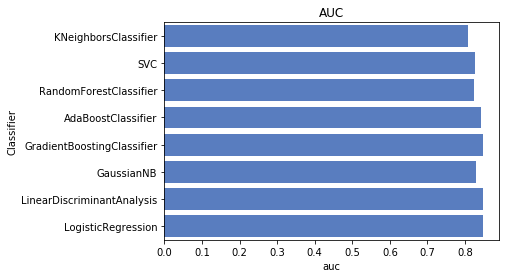

In [16]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
#     DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

auc_cols = ['Classifier', 'auc']
aucs = pd.DataFrame(columns=auc_cols)

sss = KFold(n_splits=3)

X = train_feat.drop('Survived', axis=1).values
y = train_feat['Survived']

acc_dict = {}
auc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_proba = clf.predict_proba(X_test)
        train_proba_y = train_proba[:,np.where(clf.classes_==1)[0][0]]
#         print(train_proba_y)
        auc = roc_auc_score(y_test, train_proba_y)
        if name in auc_dict:
            auc_dict[name] += auc
        else:
            auc_dict[name] = auc

for clf in auc_dict:
    auc_dict[clf] = auc_dict[clf] / 3
    auc_entry = pd.DataFrame([[clf, auc_dict[clf]]], columns=auc_cols)
    aucs = aucs.append(auc_entry)

print(aucs)
    
plt.xlabel('Accuracy')
plt.title('AUC')


sns.set_color_codes("muted")
sns.barplot(x='auc', y='Classifier', data=aucs, color="b")

## 增加名字特征

In [17]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

def get_name_feature(dataset):
    dataset = dataset.copy()
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    return dataset['Title']

In [18]:
train_feat['Title'] = get_name_feature(train)
test_feat['Title'] = get_name_feature(test)

In [19]:
train_feat

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1.0,0,0,0,1
1,1,1,0,2.0,3,1,0,3
2,1,3,0,1.0,1,0,1,2
3,1,1,0,2.0,3,0,0,3
4,0,3,1,2.0,1,0,1,1
5,0,3,1,2.0,1,2,1,1
6,0,1,1,3.0,3,0,1,1
7,0,3,1,0.0,2,0,0,4
8,1,3,0,1.0,1,0,0,3
9,1,2,0,0.0,2,1,0,3


D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



                   Classifier       auc
0        KNeighborsClassifier  0.801748
0                         SVC  0.842618
0      RandomForestClassifier  0.830725
0          AdaBoostClassifier  0.853279
0  GradientBoostingClassifier  0.859862
0                  GaussianNB  0.833788
0  LinearDiscriminantAnalysis  0.857221
0          LogisticRegression  0.857808


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



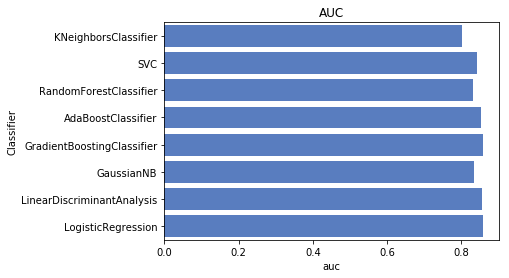

In [21]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
#     DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

auc_cols = ['Classifier', 'auc']
aucs = pd.DataFrame(columns=auc_cols)

sss = KFold(n_splits=3)

X = train_feat.drop('Survived', axis=1).values
y = train_feat['Survived']

acc_dict = {}
auc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_proba = clf.predict_proba(X_test)
        train_proba_y = train_proba[:,np.where(clf.classes_==1)[0][0]]
#         print(train_proba_y)
        auc = roc_auc_score(y_test, train_proba_y)
        if name in auc_dict:
            auc_dict[name] += auc
        else:
            auc_dict[name] = auc

for clf in auc_dict:
    auc_dict[clf] = auc_dict[clf] / 3
    auc_entry = pd.DataFrame([[clf, auc_dict[clf]]], columns=auc_cols)
    aucs = aucs.append(auc_entry)

print(aucs)
    
plt.xlabel('Accuracy')
plt.title('AUC')


sns.set_color_codes("muted")
sns.barplot(x='auc', y='Classifier', data=aucs, color="b")

# 模型融合

In [22]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 6 # for reproducibility
NFOLDS = 3 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
#         params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [23]:
# 这一个有什么用？
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [24]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# GaussianNB parameters 
gnb_params = {
    }

lda_params = {
    }

lr_params = {
    }



In [25]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
gnb = SklearnHelper(clf=GaussianNB, seed=SEED, params=gnb_params)
lda = SklearnHelper(clf=LinearDiscriminantAnalysis, seed=SEED, params=lda_params)
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)

## 准备数据

In [26]:
x_train = train_feat.drop('Survived', axis=1).values
y_train = train_feat['Survived'].values
x_test = test_feat.values

In [27]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
gnb_oof_train, gnb_oof_test = get_oof(gnb,x_train, y_train, x_test) # Support Vector Classifier
lda_oof_train, lda_oof_test = get_oof(lda,x_train, y_train, x_test) # Support Vector Classifier
lr_oof_train, lr_oof_test = get_oof(lr,x_train, y_train, x_test) # Support Vector Classifier


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:310: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:310: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [34]:
et_feature = et.feature_importances(x_train, y_train)
rf_feature = rf.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)
# svc_feature = svc.feature_importances(x_train,y_train)
# gnb_feature = gnb.feature_importances(x_train,y_train)
# lda_feature = lda.feature_importances(x_train,y_train)
# lr_feature = lr.feature_importances(x_train,y_train)

[0.19334189 0.38951562 0.05110738 0.08785285 0.04369175 0.0351166
 0.19937391]
[0.20703049 0.23202406 0.05870664 0.1174321  0.04737171 0.03490722
 0.30252778]


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:310: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[0.022 0.332 0.018 0.042 0.024 0.014 0.548]
[0.18007398 0.02763468 0.06757764 0.10155824 0.03556167 0.01949514
 0.56809865]


In [42]:
rf_features = [0.2000315 , 0.23905176, 0.05773036, 0.1099633,  0.04217452 ,0.03687051, 0.31417805]
et_features = [0.18930928, 0.39527312, 0.04442942, 0.09030344, 0.04131129, 0.03559124, 0.2037822 ]
ada_features = [0.022 , 0.332, 0.018, 0.042, 0.024, 0.014, 0.548]
gb_features = [0.17974553, 0.02735145, 0.06774299, 0.10158208, 0.03543681, 0.01955919, 0.56858196]
print(test_feat.columns.values)

['Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'IsAlone' 'Title']


In [43]:
cols = test_feat.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [45]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [29]:
base_predictions_train = pd.DataFrame( {
        'ExtraTrees': et_oof_train.ravel(),
        'RandomForest': rf_oof_train.ravel(),
        'AdaBoost': ada_oof_train.ravel(),
        'GradientBoost': gb_oof_train.ravel(),
        'Support Vector': svc_oof_train.ravel(),
        'GaussNB':gnb_oof_train.ravel(),
        'LDA':lda_oof_train.ravel(),
        'LR':lr_oof_train.ravel()
    })
base_predictions_train.head()

,ExtraTrees,RandomForest,AdaBoost,GradientBoost,Support Vector,GaussNB,LDA,LR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [164]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, gnb_oof_train,lda_oof_train, lr_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, gnb_oof_test, lda_oof_test, lr_oof_test), axis=1)

In [184]:
xgb_params  = {
    'n_estimators' : 1000,
    'eta': 0.02, 
    'max_depth': 5,
    'gamma' : 0.9,
    'subsample': 0.8, 
    'min_child_weight':2,
    'colsample_bytree': 0.8, 
    'objective': 'binary:logistic',
    'seed': 99, 'silent': 1, 
    'eval_metric':'auc', 
    'nthread':4,
    'scale_pos_weight' : 1
}
early_stopping = 10

In [175]:
gbm = xgb.XGBClassifier(**xgb_params).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [169]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': test['PassengerId'].values,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission2.csv", index=False)

In [185]:
xg_train = xgb.DMatrix(x_train, label=y_train);
cv = xgb.cv(xgb_params, xg_train, 50000, nfold=3, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.84239+0.00600702	test-auc:0.833937+0.0122053
[1]	train-auc:0.842763+0.00652405	test-auc:0.834863+0.0128916
[2]	train-auc:0.846284+0.00873901	test-auc:0.834228+0.0131382
[3]	train-auc:0.850002+0.0028855	test-auc:0.842314+0.00470324
[4]	train-auc:0.850063+0.00288318	test-auc:0.842971+0.00318569
[5]	train-auc:0.848629+0.00245952	test-auc:0.843822+0.00406912
[6]	train-auc:0.849114+0.00255503	test-auc:0.843718+0.0041324
[7]	train-auc:0.849606+0.00289082	test-auc:0.843513+0.00403889
[8]	train-auc:0.851441+0.00188069	test-auc:0.847619+0.00540695
[9]	train-auc:0.851738+0.00203609	test-auc:0.848509+0.00427682
[10]	train-auc:0.85175+0.00240832	test-auc:0.84844+0.00454328
[11]	train-auc:0.85181+0.00269779	test-auc:0.84934+0.00473601
[12]	train-auc:0.852029+0.00263169	test-auc:0.849159+0.00484067
[13]	train-auc:0.852235+0.0026709	test-auc:0.849243+0.00465093
[14]	train-auc:0.852278+0.00275919	test-auc:0.849209+0.00473419
[15]	train-auc:0.852842+0.00228474	test-auc:0.849284+0.004743

In [182]:
cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.842390,0.006007,0.833937,0.012205
1,0.842763,0.006524,0.834863,0.012892
2,0.846284,0.008739,0.834228,0.013138
3,0.850002,0.002886,0.842314,0.004703
4,0.850063,0.002883,0.842971,0.003186
5,0.848629,0.002460,0.843822,0.004069
6,0.849114,0.002555,0.843718,0.004132
7,0.849606,0.002891,0.843513,0.004039
8,0.851441,0.001881,0.847619,0.005407
9,0.851738,0.002036,0.848509,0.004277


In [188]:
xg_train